In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import ADASYN

In [2]:
df = pd.read_csv('03_Cleaned_File(Data Preprocessing).csv')

In [3]:
df.head()

,CustomerId,Surname,CreditScore,Gender,Age,EstimatedSalary,Balance,NumOfProducts,HasCrCard,Tenure,IsActiveMember,Exited,Geography_Germany,Geography_Spain
0,15634602,Hargrave,619,0,42,101348.88,0.00,1,1,2,1,1,0,0
1,15647311,Hill,608,0,41,112542.58,83807.86,1,1,1,1,0,0,1
2,15619304,Onio,502,0,42,113931.57,159660.80,3,0,8,0,1,0,0
3,15701354,Boni,699,0,39,93826.63,0.00,2,0,1,0,0,0,0
4,15737888,Mitchell,850,0,43,79084.10,125510.82,1,1,2,1,0,0,1


In [4]:
X = df.drop(columns = ['CustomerId', 'Surname', 'Exited'])
y = df['Exited']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [6]:
scaler = StandardScaler()
columns = ['CreditScore', 'Age', 'EstimatedSalary', 'Balance']
X_train[columns] = scaler.fit_transform(X_train[columns])
X_test[columns] = scaler.transform(X_test[columns])

In [7]:
y_train.value_counts()

Exited
0    5992
1    1505
Name: count, dtype: int64

In [8]:
over_samp = ADASYN(random_state=42)
X_train, y_train = over_samp.fit_resample(X_train, y_train)

In [9]:
y_train.value_counts()

Exited
1    6118
0    5992
Name: count, dtype: int64

In [10]:
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

In [11]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [12]:
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}
grid_search = GridSearchCV(
    estimator = xgb,
    param_grid = param_grid,
    scoring = scoring, 
    cv = 5,
    refit = 'recall'
)

In [13]:
grid_search.fit(X_train, y_train)

c:\Users\amand\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:34:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\amand\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:34:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\amand\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:34:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\amand\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:34:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtr

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.8, 1.0]},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

In [14]:
grid_search.best_params_

{'colsample_bytree': 1.0,
 'learning_rate': 0.2,
 'max_depth': 5,
 'n_estimators': 300,
 'subsample': 0.7}

In [15]:
best_dt = grid_search.best_estimator_
y_pred = best_dt.predict(X_test)

In [16]:
cm = confusion_matrix(y_pred, y_test)
cm

array([[1728,  220],
       [ 240,  312]], dtype=int64)

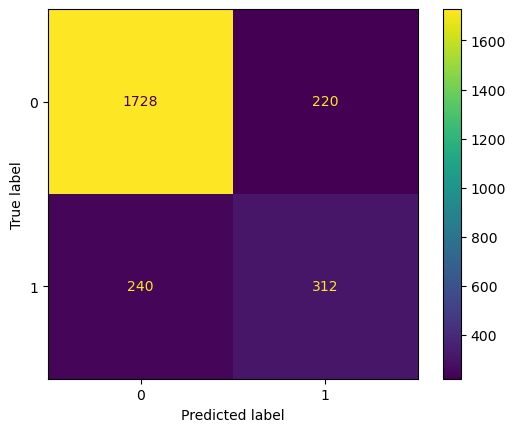

In [17]:
ConfusionMatrixDisplay(confusion_matrix = cm).plot()

In [18]:
class0_accuracy = cm[0,0] / cm[0].sum()
class1_accuracy = cm[1,1] / cm[1].sum()
print(f"Class 0 Accuracy: {class0_accuracy:.2f}")
print(f"Class 1 Accuracy: {class1_accuracy:.2f}")

Class 0 Accuracy: 0.89
Class 1 Accuracy: 0.57


In [19]:
print(f'Accuracy : {accuracy_score(y_test, y_pred):.2f}')
print(f'Precision : {precision_score(y_test, y_pred):.2f}')
print(f'Recall : {recall_score(y_test, y_pred):.2f}')
print(f'F1 Score : {f1_score(y_test, y_pred):.2f}')

Accuracy : 0.82
Precision : 0.57
Recall : 0.59
F1 Score : 0.58


In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88      1968
           1       0.57      0.59      0.58       532

    accuracy                           0.82      2500
   macro avg       0.73      0.73      0.73      2500
weighted avg       0.82      0.82      0.82      2500

